# Learning Tree-augmented Bayesian Network (TAN) Structure from Data

## First, create a Naive Bayes graph

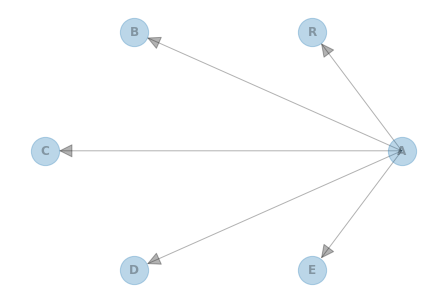

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models.BayesianModel import BayesianModel

# class variable is A and feature variables are B, C, D, E and R
model = BayesianModel([('A', 'R'), ('A', 'B'), ('A', 'C'), ('A', 'D'), ('A', 'E')])
nx.draw_circular(model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight='bold')
plt.show()


## Second, add interaction between the features

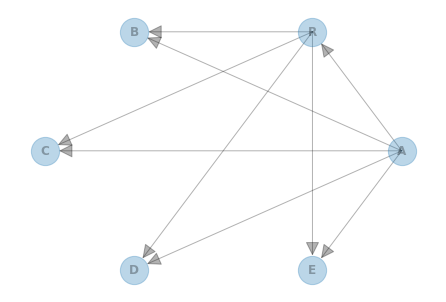

In [2]:
# feature R correlates with other features
model.add_edges_from([('R', 'B'), ('R', 'C'), ('R', 'D'), ('R', 'E')])
nx.draw_circular(model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight='bold')
plt.show()


## Then, parameterize our graph to create a Bayesian network

In [3]:
from pgmpy.factors.discrete import TabularCPD

# add CPD to each edge
cpd_a = TabularCPD('A', 2, [[0.7], [0.3]])
cpd_r = TabularCPD('R',3,[[0.6,0.2],[0.3,0.5],[0.1,0.3]],evidence=['A'], evidence_card=[2])
cpd_b = TabularCPD('B',3,[[0.1,0.1,0.2,0.2,0.7,0.1],
                          [0.1,0.3,0.1,0.2,0.1,0.2],
                          [0.8,0.6,0.7,0.6,0.2,0.7]],
                          evidence=['A','R'], evidence_card=[2,3])
cpd_c = TabularCPD('C',2,[[0.7,0.2,0.2,0.5,0.1,0.3],
                          [0.3,0.8,0.8,0.5,0.9,0.7]],
                          evidence=['A','R'], evidence_card=[2,3])
cpd_d = TabularCPD('D',3,[[0.3,0.8,0.2,0.8,0.4,0.7],
                          [0.4,0.1,0.4,0.1,0.1,0.1],
                          [0.3,0.1,0.4,0.1,0.5,0.2]],
                          evidence=['A','R'], evidence_card=[2,3])
cpd_e = TabularCPD('E',2,[[0.5,0.6,0.6,0.5,0.5,0.4],
                          [0.5,0.4,0.4,0.5,0.5,0.6]],
                          evidence=['A','R'], evidence_card=[2,3])
model.add_cpds(cpd_a, cpd_r, cpd_b, cpd_c, cpd_d, cpd_e)


## Next, generate sample data from our Bayesian network

In [4]:
from pgmpy.sampling import BayesianModelSampling

# sample data from BN
inference = BayesianModelSampling(model)
df_data = inference.forward_sample(size=10000, return_type='dataframe')
print(df_data)


Generating for node: B: 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]

      A  R  E  D  C  B
0     0  1  1  0  1  2
1     0  2  0  0  1  2
2     0  0  0  2  0  2
3     0  0  0  0  0  2
4     1  2  0  0  0  2
...  .. .. .. .. .. ..
9995  0  0  1  1  1  2
9996  0  2  0  2  1  2
9997  0  1  0  2  1  2
9998  0  1  1  0  0  2
9999  0  2  1  1  1  2

[10000 rows x 6 columns]


## Now we are ready to learn the TAN structure from sample data

Building tree: 100%|██████████| 10/10.0 [00:00<00:00, 480.26it/s]


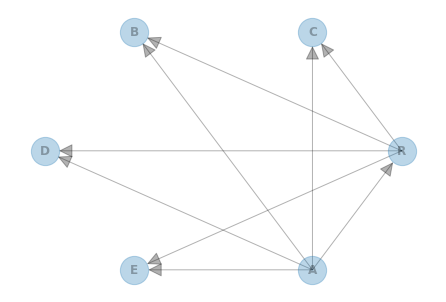

In [5]:
from pgmpy.estimators import TreeSearch

# learn graph structure 
est = TreeSearch(df_data, root_node='R')
dag = est.estimate(estimator_type="tan", class_node="A")
nx.draw_circular(dag, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight='bold')
plt.show()


## To parameterize the learned graph from data, check out the other tutorials for more info

In [6]:
from pgmpy.estimators import BayesianEstimator

# there are many choices of parametrization, here is one example
model = BayesianModel(dag.edges())
model.fit(df_data, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=0.1)
model.get_cpds()

[<TabularCPD representing P(R:3 | A:2) at 0x7f3a572a4610>,
 <TabularCPD representing P(C:2 | A:2, R:3) at 0x7f3a556adbe0>,
 <TabularCPD representing P(B:3 | A:2, R:3) at 0x7f3a55717ca0>,
 <TabularCPD representing P(D:3 | A:2, R:3) at 0x7f3a572a4820>,
 <TabularCPD representing P(E:2 | A:2, R:3) at 0x7f3a5716db20>,
 <TabularCPD representing P(A:2) at 0x7f3a572a4640>]